## Simple tests for grabbing frames

Simple CV has a nice wrapper around webcams.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
np.set_printoptions(precision=2, suppress=True)
# define plots to be inserted interactively
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [3]:
class Source:
    def __init__(self, w=640, h=480):
        self.h, self.w = h, w
        import cv2
        self.cap = cv2.VideoCapture(0)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, self.w)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, self.h)

        
    def grab(self):
        # grab a frame
        returned, cam_data = self.cap.read()
        data = cam_data.reshape((self.h, self.w, 3))
        return data
    
    def close(self):
        self.cap.release()

start = time.time()
cam = Source()
cam.close()
print('Time to start and stop the camera = ',  time.time() - start , '(s)')

Time to start and stop the camera =  1.789330005645752 (s)


Time to start, grab 2 frames and stop =  2.3922650814056396 (s)
(480, 640, 3) 0 142


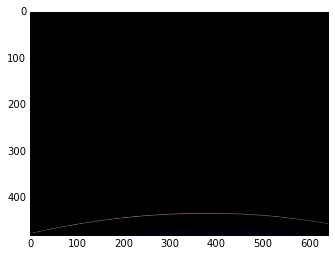

In [4]:
start = time.time()
cam = Source()
img = cam.grab()
img = cam.grab()
cam.close()
print('Time to start, grab 2 frames and stop = ',  time.time() - start , '(s)')
print(img.shape, img.min(), img.max())
plt.imshow(img)

## how fast do we grab frames?

In [5]:
N = 100
ctime = np.zeros(N)
start = time.time()
cam = Source()
for i in range(N):
    img = cam.grab()
    ctime[i] = time.time() - start
cam.close()

FPS :  12.1685856524


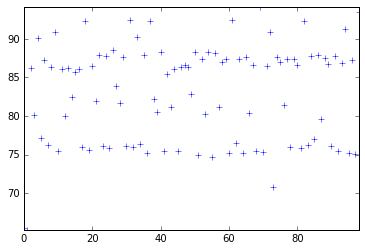

In [6]:
plt.plot(np.diff(ctime)*1000, '+')
_ = plt.axis('tight')

print ('FPS : ',  N/(ctime[-1]-ctime[0]))

## closing the camera

In [7]:
cam.cap.isOpened()

False

In [8]:
cam.cap.release()

## threaded mode


In [19]:
from multiprocessing.pool import ThreadPool
from collections import deque
import cv2

class StatValue:
    def __init__(self, smooth_coef = 0.5):
        self.value = None
        self.smooth_coef = smooth_coef
    def update(self, v):
        if self.value is None:
            self.value = v
        else:
            c = self.smooth_coef
            self.value = c * self.value + (1.0-c) * v

def clock():
    return cv2.getTickCount() / cv2.getTickFrequency()

def draw_str(dst, target, s):
    x, y = target
    cv2.putText(dst, s, (x+1, y+1), cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 0), thickness = 2, lineType=cv2.LINE_AA)
    cv2.putText(dst, s, (x, y), cv2.FONT_HERSHEY_PLAIN, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)


class ThreadSource:
    def __init__(self, w=640, h=480):
        self.h, self.w = h, w
        import cv2
        self.cap = cv2.VideoCapture(0)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, self.w)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, self.h)

        self.threadn = cv2.getNumberOfCPUs()
        self.pool = ThreadPool(processes = self.threadn)
        self.pending = deque()

        self.latency = StatValue()
        self.frame_interval = StatValue()
        self.last_frame_time = clock()        
        self.display = False
        self.ctime = []
        self.N = 0

    def process_frame(self, frame, t0):
        # some intensive computation...
        #frame = cv2.medianBlur(frame, 19)
        #frame = cv2.medianBlur(frame, 19)
        return frame, t0

    def run(self, T=10):
        start = clock()
        while clock()-start <10.:
            while len(self.pending) > 0 and self.pending[0].ready():
                res, t0 = self.pending.popleft().get()
                self.latency.update(clock() - t0)
                if self.display:
                    draw_str(res, (20, 40), "latency        :  %.1f ms" % (self.latency.value*1000))
                    draw_str(res, (20, 60), "frame interval :  %.1f ms" % (self.frame_interval.value*1000))
                    cv2.imshow('Webcam video', res)
                self.ctime.append(time.time() - start)
                self.N += 1
            if len(self.pending) < self.threadn:
                ret, frame = self.cap.read()
                t = clock()
                self.frame_interval.update(t - self.last_frame_time)
                self.last_frame_time = t
                task = self.pool.apply_async(self.process_frame, (frame.copy(), t))
                self.pending.append(task)
            ch = 0xFF & cv2.waitKey(1)
            if ch == 27:
                self.close()
    
    def close(self):
        self.cap.release()
        if self.display: cv2.destroyAllWindows()

start = time.time()
cam = ThreadSource()
ctime = cam.run()
cam.close()

FPS :  12.153618250085021


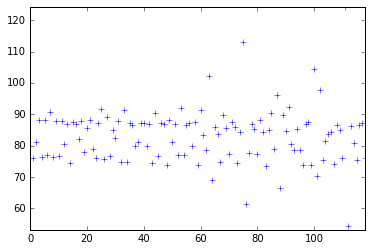

In [20]:
plt.plot(np.diff(np.array(cam.ctime))*1000, '+')
_ = plt.axis('tight')
print ('FPS : ',  cam.N/(cam.ctime[-1]-cam.ctime[0]))